<a href="https://colab.research.google.com/github/benkrikler/wavefilter/blob/main/notebooks/train_simple_pulse_finder_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall -y wavefilter
!pip install "git+https://github.com/benkrikler/wavefilter#egg=wavefilter"

Found existing installation: wavefilter 0.0.1
Uninstalling wavefilter-0.0.1:
  Successfully uninstalled wavefilter-0.0.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/benkrikler/wavefilter to /tmp/pip-install-8mwuaor1/wavefilter_504fc3763ead4cc4a91a4ddf489e5ec0
  Running command git clone -q https://github.com/benkrikler/wavefilter /tmp/pip-install-8mwuaor1/wavefilter_504fc3763ead4cc4a91a4ddf489e5ec0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for wavefilter: filename=wavefilter-0.0.1-py3-none-any.whl size=8628 sha256=c8b9db09d21e88653207cf943f41748a675ccf261cb54d5b2c2acd1e066860c2
  Stored in directory: /tmp/pip-ephem-wheel-cache-_8qick3_/wheels/90/df/9f/9270370fe3646030b374f3d85d149fae54db3182db8119bb26
Successfully built wavefilter


In [2]:
import numpy as np
import pandas as pd
import logging
import torch
from torch import nn
import torch.nn.functional as F
import wavefilter
import wavefilter.datasets as wds
import wavefilter.pulse_functions as wps
import wavefilter.models as models
from wavefilter.evaluate import split_parameters, train_parallel_pulse_finder, CaptureActivations
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
wavefilter.evaluate.logging.basicConfig(level=logging.INFO)

Using cuda device


## Make some data

In [3]:
n_samples = 5000 if device == "cpu" else 10000
data, truth = wds.generate_double_pulse_dataset(n_samples, in_noise=0.05, out_noise=2, shape=40, dt2_low=150, dt2_high=700)
# Add an extra dimension for the channel number
data

array([[ 0.04912134,  3.267931  ,  0.97547626, ..., -2.0180216 ,
         1.5015883 ,  0.4082596 ],
       [-0.3773542 ,  0.22916311,  3.0653107 , ..., -1.1660823 ,
         4.251436  , -2.1693878 ],
       [-1.6094977 , -3.1251662 ,  0.7145797 , ..., -2.401905  ,
         1.3162534 , -0.7414323 ],
       ...,
       [ 1.6474267 , -0.35106936,  2.979861  , ...,  5.458569  ,
        -1.2171744 ,  4.915734  ],
       [-3.329931  , -3.0685368 , -3.5687244 , ...,  3.3009362 ,
        -1.1713775 , -1.2275832 ],
       [ 0.21987851, -1.0669384 , -0.05974327, ..., -1.5469291 ,
         1.4440255 ,  1.3836869 ]], dtype=float32)

In [4]:
ds = wds.to_torch_dataset(data)
train_loader = torch.utils.data.DataLoader(ds, batch_size=100, shuffle=False)
for i, d in enumerate(train_loader):
  print(f"i={i}")
  print([(dd.shape, dd.mean) for dd in d])
  if i > 2: 
    break

i=0
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f40745a66b0>)]
i=1
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f3fe6dd5530>)]
i=2
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f3fe6dd8530>)]
i=3
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f3fe6dda530>)]


## Set up the model

In [25]:
class Conv1dPulseFinderAttention_v4(models.Conv1dPulseFinderAttentionBase):
    def forward(self, ampl: torch.Tensor, original: torch.Tensor):
        inputs = super().forward_step1(ampl, original)
        inputs = torch.roll(inputs, self.pulse_finder.weight.shape[-1] //2, -1)
       # scale = self.scale(inputs)
       # attend = torch.tanh(F.softshrink(scale))
       # return F.softmax(attend, -1)
        attend = F.leaky_relu(inputs)
        attend = self.scale(attend)
        #attend = torch.sigmoid(attend)
        attend = F.softmax(attend, -1)
        return attend

attention = models.ParallelWeightedModules()
attention.add("conv_pulse_finder", Conv1dPulseFinderAttention_v4(100, False), 0)
attention.add("soft_max", models.GlobalSoftMaxAttention(), 1)

model = models.WaveFilter(200, attention).to(device)
#model = models.WaveFilter(200, models.GlobalSoftMaxAttention()).to(device)
print(model)

WaveFilter(
  (convolve): Conv1d(1, 1, kernel_size=(200,), stride=(1,), padding=same)
  (attend): ParallelWeightedModules(
    module_weights=(conv_pulse_finder=0,soft_max=1)
    (conv_pulse_finder): Conv1dPulseFinderAttention_v4(
      (pulse_finder): Conv1d(1, 1, kernel_size=(100,), stride=(1,), padding=same)
      (combine): Conv1d(2, 1, kernel_size=(5,), stride=(1,), padding=same)
      (scale): Conv1d(1, 1, kernel_size=(1,), stride=(1,), padding=same)
    )
    (soft_max): GlobalSoftMaxAttention()
  )
  (encode): Product()
  (reconstruct): TiedFlippedConvolve1D(
    (tied_to): Conv1d(1, 1, kernel_size=(200,), stride=(1,), padding=same)
  )
)


In [26]:
params = split_parameters(model, ['attend'])
params

[{'params': [Parameter containing:
   tensor([[[-0.0800,  0.0691, -0.0583, -0.0797, -0.0274,  0.0269,  0.0466,
              0.0897,  0.0184,  0.0321,  0.0184, -0.0753, -0.0904,  0.0340,
              0.0638, -0.0778,  0.0352, -0.0043, -0.0255,  0.0236, -0.0553,
             -0.0089, -0.0805,  0.0120, -0.0895, -0.0667,  0.0705,  0.0902,
              0.0695, -0.0375, -0.0515, -0.0913,  0.0762, -0.0426, -0.0903,
              0.0515, -0.0085,  0.0162,  0.0595,  0.0507,  0.0586,  0.0479,
              0.0355,  0.0089, -0.0675, -0.0903, -0.0746,  0.0791, -0.0847,
              0.0403,  0.0964,  0.0974,  0.0953, -0.0945,  0.0007,  0.0376,
              0.0063, -0.0205, -0.0217,  0.0370, -0.0047,  0.0084, -0.0385,
              0.0810, -0.0848,  0.0670, -0.0708, -0.0194, -0.0131, -0.0272,
             -0.0192, -0.0430,  0.0083, -0.0842,  0.0194,  0.0010,  0.0095,
             -0.0202, -0.0336,  0.0903, -0.0119,  0.0314,  0.0285,  0.0356,
              0.0690,  0.0613,  0.0988, -0.0948,  0.0

In [27]:
lr_schedules = [lambda x: 0.99, lambda x: 0.95**x]
tester = train_parallel_pulse_finder(train_loader, model, param_groups=params,
                                     lr_schedules=lr_schedules, device=device,
                                     epochs=300,
                                     start_incrementing = 90,
                                     epochs_per_increment = 100,
                                     change_per_increment = 0.5,
)

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

## Inspect what we've learnt

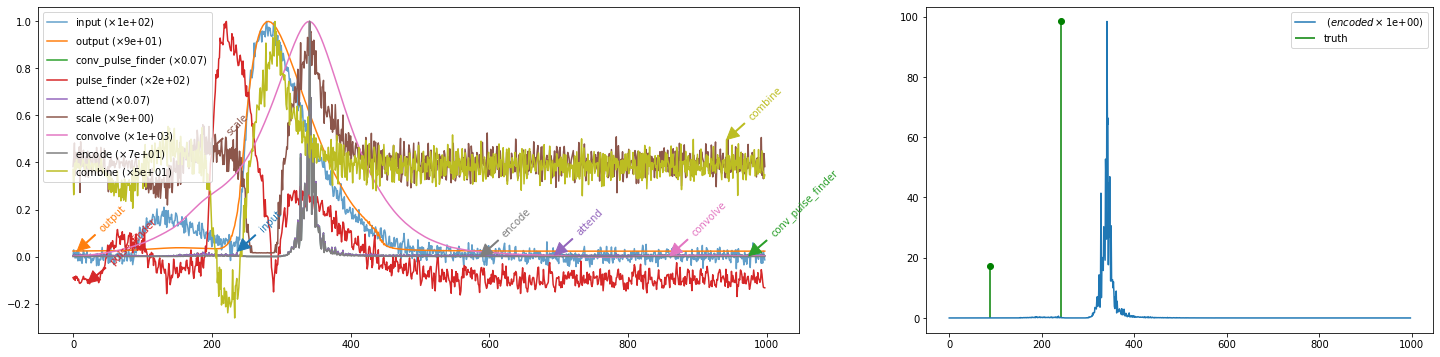

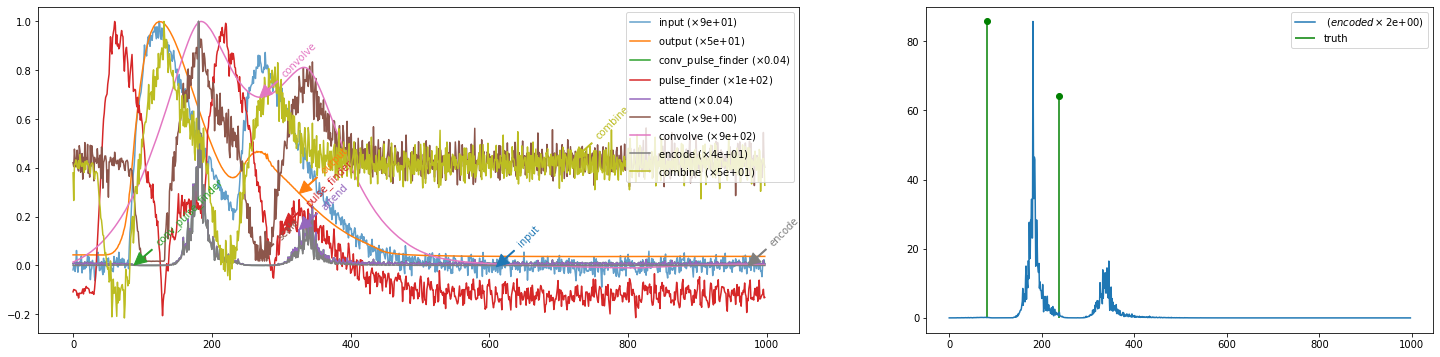

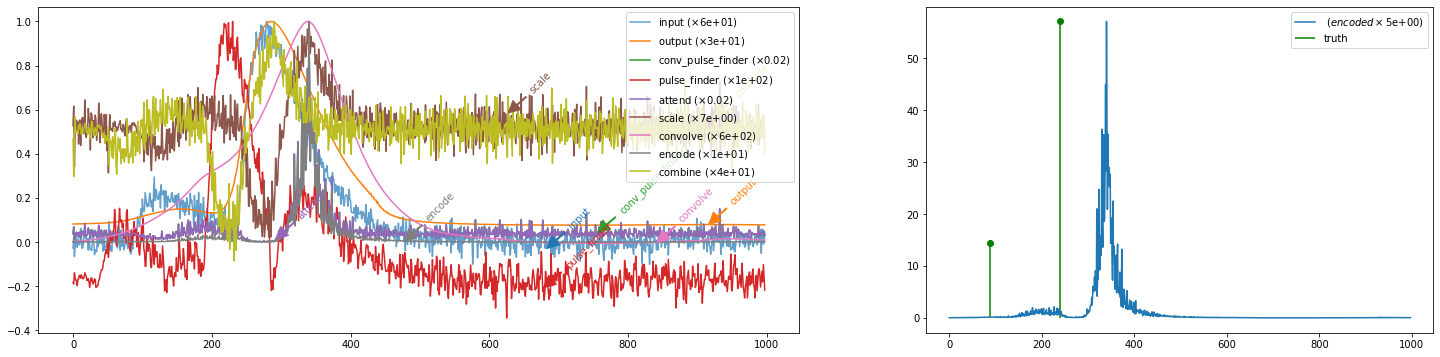

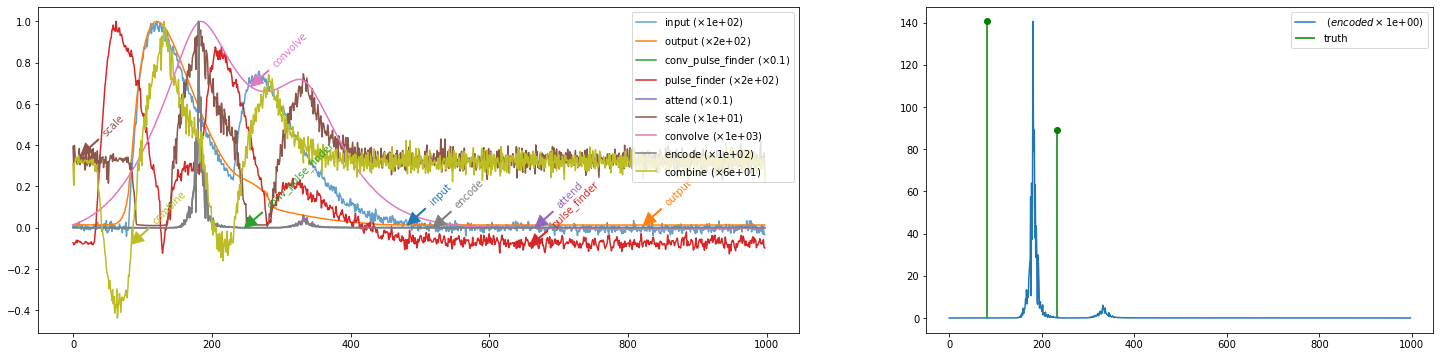

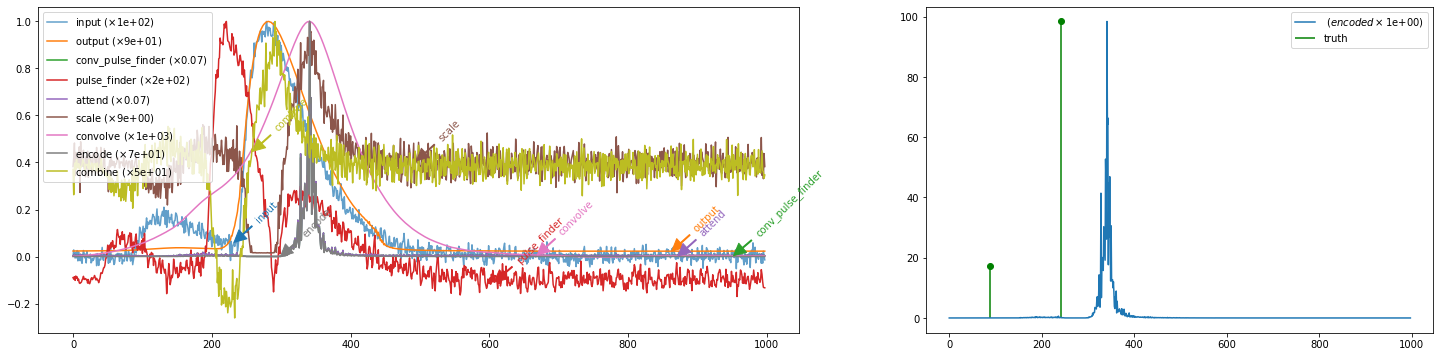

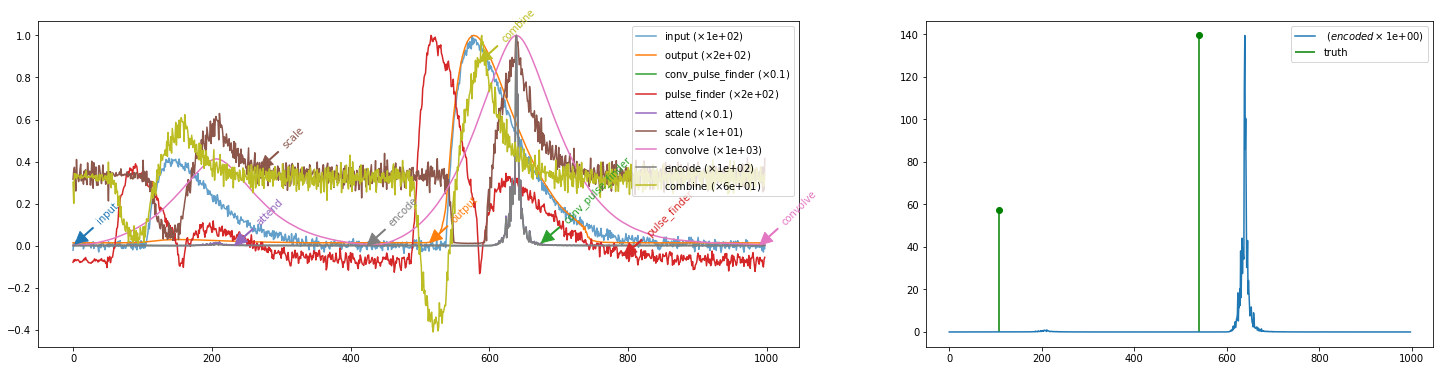

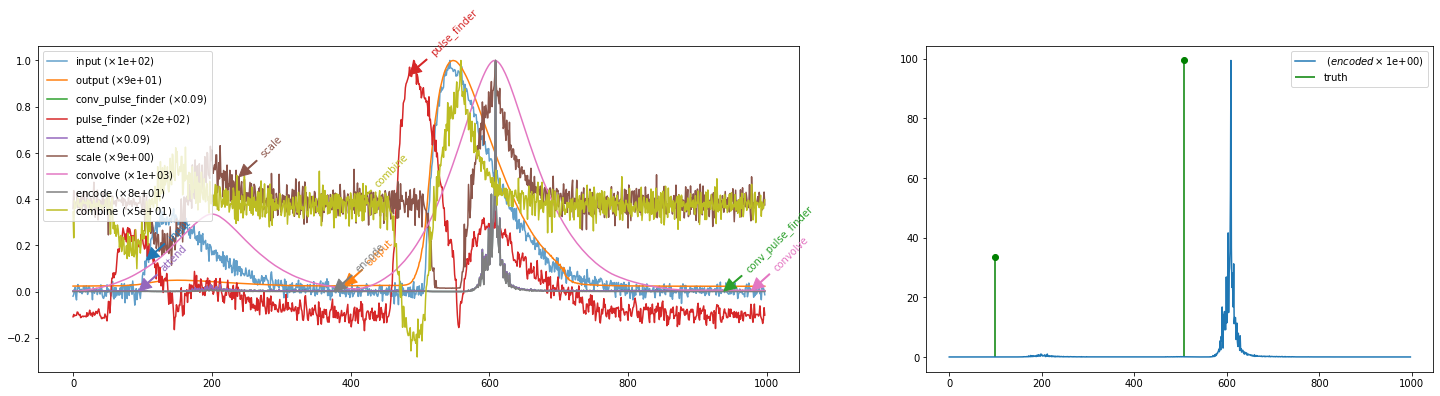

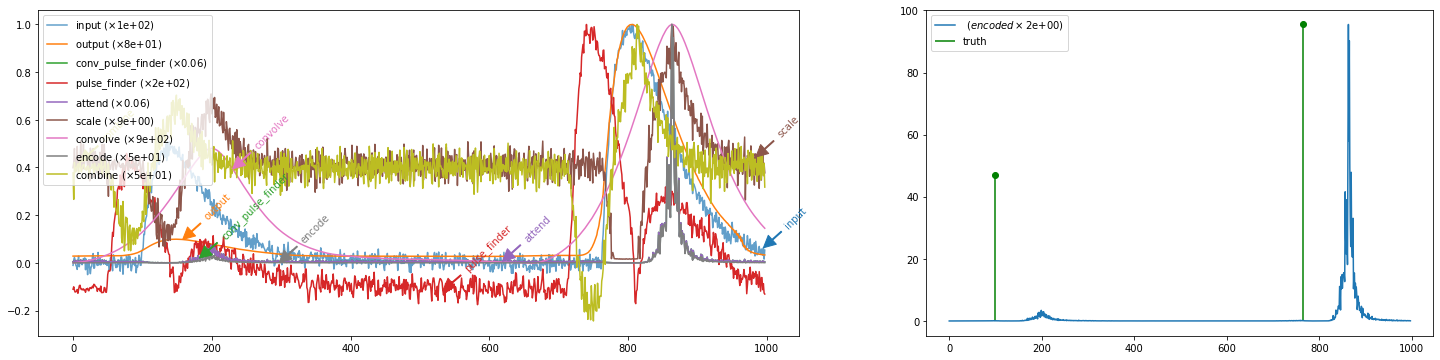

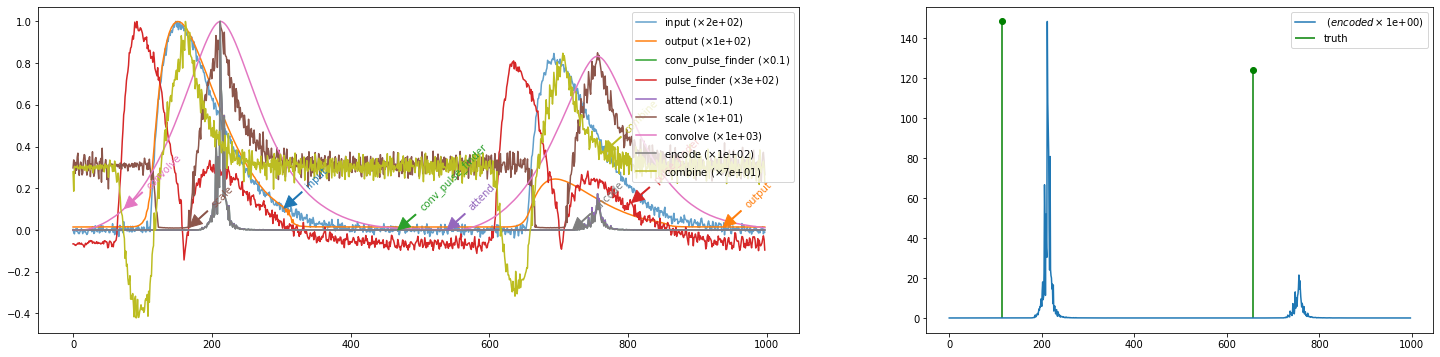

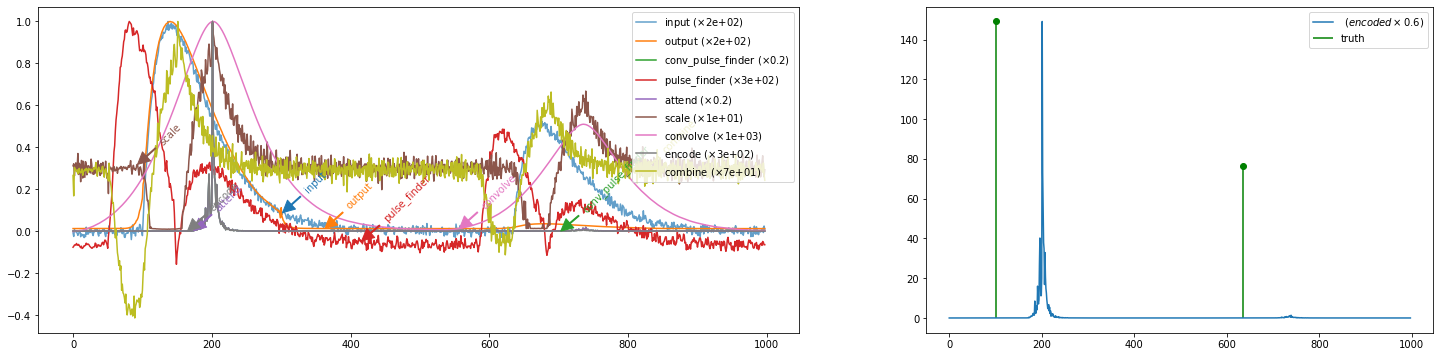

In [28]:
activations = CaptureActivations()
activations.register(model, "attend", "encode", "convolve", "reconstruct")
activations.register(model.attend, "conv_pulse_finder", "soft_max")
activations.register(model.attend.conv_pulse_finder, "pulse_finder", "combine", "scale")

def plot_line(data, label, **kwargs):
  scale = max(data.max(), -data.min())
  lines = plt.plot(data / scale, label=f"{label} ($\\times${scale:.01})", **kwargs)
  x = np.random.randint(len(data))
  y = data[x] / scale
  color = lines[0].get_color()
  plt.annotate(label, (x,y), xycoords="data", textcoords="offset points", xytext=(20,20), arrowprops=dict(width=1, color=color), color=color , rotation=45)
  

def plot_prediction(model, input):
  output = model(input.to(device))
  plot_line(input[0], label="input", alpha=0.7)
  plot_line(output[0].detach().cpu().numpy(), label="output")
  for i in ['conv_pulse_finder', 'pulse_finder', 'attend', 'scale', 'convolve' , 'encode', 'combine']:
  #for i in ['convolve', 'pulse_finder', 'combine', 'scale', 'conv_pulse_finder', 'soft_max', 'attend', 'encode', 'reconstruct']:
    plot_line(activations[i][0].cpu(), label=i)
  plt.legend()
  #plt.yscale("log")

def plot_encoded(model, input, true_amp, true_time):
  model(input.to(device))
  max_amp = max(true_amp)
  encoded = activations["encode"][0].cpu().numpy()
  scale = max_amp / encoded.max()
  encoded *= scale
  plt.plot(encoded, label=f" ($encoded \\times${scale:.01})")
  plt.vlines(true_time, 0, true_amp, color="green", label="truth")
  plt.scatter(true_time[true_amp != 0], true_amp[true_amp != 0], color="green")
  plt.legend()

close_time = np.random.choice(np.where(truth[1][:, 1] < 250)[0], 5)
far_time = np.random.choice(np.where(truth[1][:, 1] > 500)[0], 5)
choices = np.concatenate((close_time, far_time))
for i in choices: #np.random.randint(len(data), size=10):
  #plt.figure(figsize=(15,6))
  _, ax = plt.subplots(1, 2,  gridspec_kw={'width_ratios': [15, 10]}, figsize=(25,6))
  plt.sca(ax[0])
  plot_prediction(model, ds[i][0])
  plt.sca(ax[1])
  plot_encoded(model, ds[i][0], truth[0][i], truth[1][i])

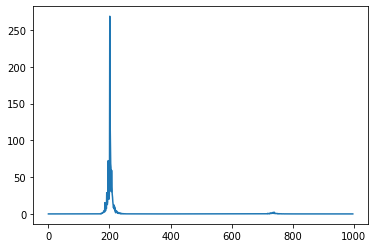

In [29]:
plt.plot(activations["encode"][0].cpu().numpy())

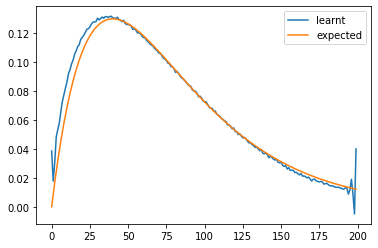

In [30]:
learnt = model.get_parameter("convolve.weight").detach().cpu().numpy()[0,0]
plt.plot(learnt, label="learnt")
expected = wps.simple(np.arange(200), 40)
expected = expected / expected[100]* learnt[100]
plt.plot(expected, label="expected")
plt.legend()

1.6509614

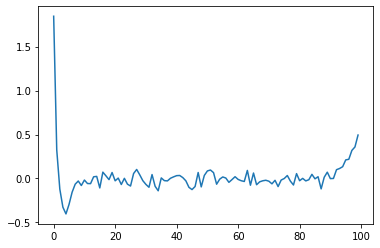

In [31]:
learnt = model.get_parameter("attend.conv_pulse_finder.pulse_finder.weight").detach().cpu().numpy()[0,0]
plt.plot(learnt)
learnt.sum()

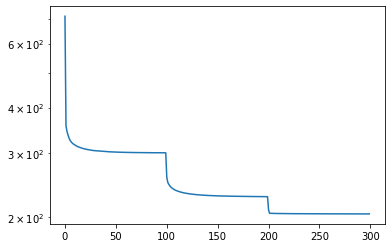

In [32]:
plt.plot(tester.train_loss);
plt.yscale("log")

In [24]:
for name, param in model.named_parameters():
  print(f"{name} = {param}")
  print()

convolve.weight = Parameter containing:
tensor([[[ 9.0661e-03,  1.5252e-03,  3.7392e-04, -6.6068e-03, -4.5024e-03,
          -5.5262e-03, -1.1999e-03, -6.6688e-04, -1.6152e-03, -7.0729e-03,
          -3.1149e-03, -8.3835e-03, -2.7670e-03, -3.9370e-03, -1.6129e-03,
          -8.1541e-03, -9.4510e-03, -7.3014e-03, -1.6150e-03, -7.9903e-05,
          -4.9615e-03, -1.0491e-02, -5.2932e-03, -1.0769e-02, -1.0349e-02,
          -1.4842e-02, -6.7721e-03, -1.4418e-02, -1.2918e-02, -2.0208e-02,
          -1.4901e-02, -2.1809e-02, -1.3225e-02, -2.1769e-02, -2.2140e-02,
          -2.8796e-02, -2.7060e-02, -2.4889e-02, -2.5361e-02, -1.8029e-02,
          -1.6398e-02, -9.3145e-03, -6.9369e-03, -1.1549e-02,  1.8474e-04,
           5.0371e-03,  2.9866e-02,  1.7082e-02,  4.5786e-02,  1.0140e-02,
           8.3984e-02,  7.6295e-02,  9.2842e-03,  2.5233e-02,  3.3328e-02,
           4.3404e-02,  3.8653e-02,  4.2823e-02,  4.1906e-02,  3.7978e-02,
           2.8361e-02,  2.7768e-02,  1.0956e-02,  1.0411e-02

In [14]:
model.attend.module_weights

{'conv_pulse_finder': 1.0, 'soft_max': 0.0}